In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
RELATIVEPATH = 'Assets\Data\dataTest\dataForce_dataTest_1_1_0.json'

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Pablo\AppData\Local\Temp\ipykernel_49252\2071717397.py:1: SyntaxWarning: invalid escape sequence '\D'
  RELATIVEPATH = 'Assets\Data\dataTest\dataForce_dataTest_1_1_0.json'


In [26]:
import json
import pandas as pd

with open(RELATIVEPATH, "r") as f:
    data = json.load(f)

rows = []

# Read top-level constants (if you want them in every row)
max_speed = data.get("maxSpeed", None)
max_force = data.get("maxForce", None)
neighbor_radius = data.get("neighborRadius", None)
alpha = data.get("alpha", None)
beta = data.get("beta", None)
delta = data.get("delta", None)
avoidance_radius = data.get("avoidanceRadius", None)
avoidance_force = data.get("avoidanceForce", None)
drone_radius = data.get("droneRadius", None)
damping_factor = data.get("dampingFactor", None)

In [27]:

rows = []

for drone_entry in data["swarmState"]:
    drone_id = int(drone_entry["droneId"])
    drone_state = drone_entry["droneState"]

    positions = drone_state.get("position", [])
    velocities = drone_state.get("velocity", [])
    obstacles = drone_state.get("obstacleAvoidance", [])
    allignement = drone_state.get("alignment", [])
    olfati = drone_state.get("olfatiSaber", [])
    embodied_list = drone_state.get("embodied", [])
    selected_list = drone_state.get("selected", [])
    network_list = drone_state.get("network", [])

    # Determine how many time steps exist for this drone
    number_of_time_steps = max(
        len(positions),
        len(velocities),
        len(embodied_list),
        len(selected_list),
        len(network_list)
    )

    for i in range(number_of_time_steps):
        # Fetch the position dictionary if it exists, otherwise {}
        if i < len(positions) and isinstance(positions[i], dict):
            pos = positions[i]
            posX = pos.get("x", None)
            posY = pos.get("y", None)
            posZ = pos.get("z", None)
        else:
            posX, posY, posZ = None, None, None

        # Fetch the velocity dictionary if it exists, otherwise {}
        if i < len(velocities) and isinstance(velocities[i], dict):
            vel = velocities[i]
            velX = vel.get("x", None)
            velY = vel.get("y", None)
            velZ = vel.get("z", None)
        else:
            velX, velY, velZ = None, None, None

        if i < len(obstacles) and isinstance(obstacles[i], dict):
            obs = obstacles[i]
            obsX = obs.get("x", None)
            obsY = obs.get("y", None)
            obsZ = obs.get("z", None)

        if i < len(olfati) and isinstance(olfati[i], dict):
            olf = olfati[i]
            olfX = olf.get("x", None)
            olfY = olf.get("y", None)
            olfZ = olf.get("z", None)

        if i < len(allignement) and isinstance(allignement[i], dict):
            all = allignement[i]
            allX = all.get("x", None)
            allY = all.get("y", None)
            allZ = all.get("z", None)

        # Booleans or other single-value lists
        emb = embodied_list[i] if i < len(embodied_list) else None
        sel = selected_list[i] if i < len(selected_list) else None
        net = network_list[i] if i < len(network_list) else None

        row_data = {
            "droneId": drone_id,
            "timeStep": i,
            "posX": posX,
            "posY": posY,
            "posZ": posZ,
            "velX": velX,
            "velY": velY,
            "velZ": velZ,
            "obsX": obsX,
            "obsY": obsY,
            "obsZ": obsZ,
            "olfX": olfX,
            "olfY": olfY,
            "olfZ": olfZ,
            "allX": allX,
            "allY": allY,
            "allZ": allZ,
            "embodied": emb,
            "selected": sel,
            "network": net
        }
        rows.append(row_data)

df = pd.DataFrame(rows)

In [28]:
# fo = Vector3.ClampMagnitude(fo, maxForce);
df['forceMagReal'] = ((df['olfX'] + df['obsX'] + df['allX'])**2 + (df['olfY'] + df['obsY'] + df['allY'])**2 + (df['olfZ'] + df['obsZ'] + df['allZ'])**2)**0.5
df['AppliedForce'] = df['forceMagReal'].apply(lambda x: min(x, max_force))

In [29]:
dfSave = df.copy()

In [30]:
droneDied = []

lifeLong = df.groupby("droneId").count()[["timeStep"]]
maxLife = lifeLong["timeStep"].max()

for drone in lifeLong.index:
    if lifeLong.loc[drone]["timeStep"] < maxLife:
        droneDied.append([drone, lifeLong.loc[drone]["timeStep"]])



In [31]:
df["crash"] = 0

for drone in droneDied:
    id = drone[0]
    timeStart = int(drone[1] - 100)
    print(id, timeStart)

    df.loc[(df["droneId"] == id) & (df["timeStep"] >= timeStart), "crash"] = 1


4 432
10 1968
11 2078
15 2077
17 2077
18 1968
19 2078


In [32]:
dfCrash = df.query("crash == 1")[["obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", 'allX', 'allY', 'allZ', 'forceMagReal', 'AppliedForce', 'droneId']]   
dfHealthy = df.query("crash == 0")[["obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", 'allX', 'allY', 'allZ', 'forceMagReal', 'AppliedForce', 'droneId']]

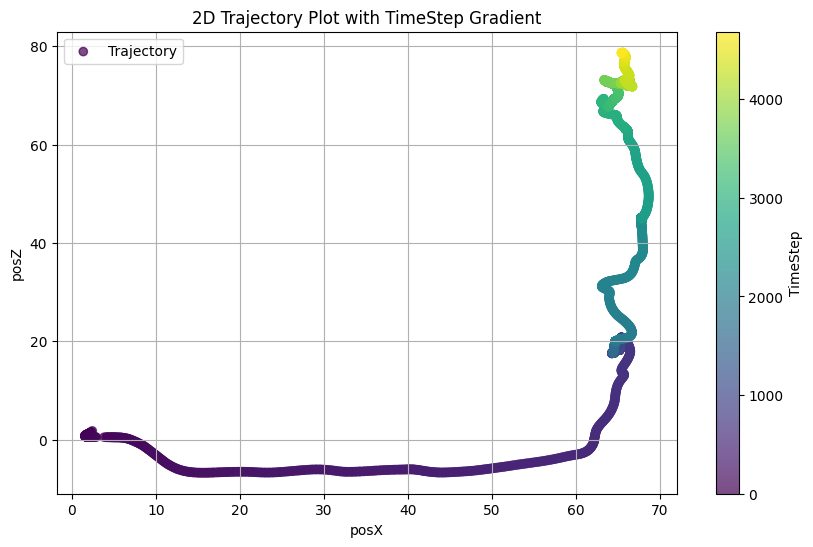

In [33]:
dfCp = df.query("droneId == 2")


plt.figure(figsize=(10, 6))
sc = plt.scatter(dfCp['posX'], dfCp['posZ'], c=dfCp['timeStep'], cmap='viridis', label='Trajectory', alpha=0.7)
plt.colorbar(sc, label='TimeStep')
plt.xlabel('posX')
plt.ylabel('posZ')
plt.title('2D Trajectory Plot with TimeStep Gradient')
plt.legend()
plt.grid(True)
plt.show()



In [24]:
dfHealthy.describe()

,obsX,obsY,obsZ,olfX,olfY,olfZ,allX,allY,allZ,forceMagReal,AppliedForce,droneId
count,3.810200e+05,381020.000000,3.810200e+05,381020.000000,381020.000000,381020.000000,381020.000000,381020.000000,381020.000000,381020.000000,381020.000000,381020.000000
mean,-2.493047e-10,-0.000841,1.620054e-08,0.004658,0.000043,0.000014,0.005606,0.005577,0.001053,0.110002,0.101982,9.500000
std,6.190474e-08,0.085369,1.648727e-06,1.691737,1.325918,1.598602,1.478532,1.305937,1.583017,0.950576,0.727494,5.766289
min,-1.135542e-05,-9.459929,0.000000e+00,-58.346619,-25.099630,-65.770462,-71.347015,-23.137369,-62.581066,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,-0.000749,-0.000881,-0.000691,-0.000663,-0.000825,-0.000761,0.000043,0.000043,4.750000
50%,0.000000e+00,0.000000,0.000000e+00,0.000005,-0.000060,0.000002,0.000000,0.000029,0.000000,0.000175,0.000175,9.500000
75%,0.000000e+00,0.000000,0.000000e+00,0.000696,0.000893,0.000927,0.000643,0.000745,0.000579,0.001082,0.001082,14.250000
max,1.045574e-05,0.000000,1.951817e-04,67.922997,25.178831,66.919746,50.092674,23.505117,61.980820,58.460366,15.000000,19.000000
